## MNIST Convolutional Neural Networks
### Goals
* TensorFlow (TF) CNNs
* Training / valication curves

### Contents
* How to use TF operators
* How to build a neural network model with TF
* How to check the model is overfitted while training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  

In [2]:
# Model parameters
# input
n_input_width = 28
n_input_height = 28
n_input_channel = 1

# 1st convolutional layer
n_conv1_patch_size = 3 
n_conv1_filter = 64

# 2nd convolutional layer
n_conv2_patch_size = 3 
n_conv2_filter = 64

# fully connected output layer
n_output  = 10 

### DRAW HERE! Convolutional filter variable size

In [3]:
# input and output placeholders
x = tf.placeholder(tf.float32, [None, n_input_width * n_input_height * n_input_channel])
y = tf.placeholder(tf.float32, [None, n_output])

# 1st convolutional layer variables
wc1 = tf.Variable(tf.random_normal([n_conv1_patch_size, n_conv1_patch_size, n_input_channel, n_conv1_filter], stddev=0.1))
bc1 = tf.Variable(tf.random_normal([n_conv1_filter], stddev=0.1))

# 2nd convolutional layer variables
wc2 = tf.Variable(tf.random_normal([n_conv2_patch_size, n_conv2_patch_size, n_conv1_filter, n_conv2_filter], stddev=0.1))
bc2 = tf.Variable(tf.random_normal([n_conv2_filter], stddev=0.1))

# fully connected output layer
# size reduced by four (2 pooling layers)
wf = tf.Variable(tf.random_normal([(n_input_width/4)*(n_input_height/4)*n_conv2_filter, n_output], stddev=0.1))
bf = tf.Variable(tf.random_normal([n_output], stddev=0.1))

In [4]:
# Reshape input: one hot vector to w x w x c tensor
input_r = tf.reshape(x, shape=[-1, n_input_width, n_input_width, n_input_channel])

# 1st Convolution layer: conv + bias + relu + pooling
# TensorFlow operators for CNNs
# https://www.tensorflow.org/api_guides/python/nn#Convolution
conv1 = tf.nn.conv2d(input_r, wc1, strides=[1, 1, 1, 1], padding='SAME')
bias1 = tf.nn.bias_add(conv1, bc1)
relu1 = tf.nn.relu(bias1)
pool1  = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 2nd Convolution layer
conv2 = tf.nn.conv2d(pool1, wc2, strides=[1, 1, 1, 1], padding='SAME')
bias2 = tf.nn.bias_add(conv2, bc2)
relu2 = tf.nn.relu(bias2)
pool2  = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Vectorize
dense = tf.reshape(pool2, [-1, wf.get_shape().as_list()[0]])

# Fully-connected layer
logits = tf.add(tf.matmul(dense, wf), bf)

In [5]:
# cost function and accuracy
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
corr = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

In [6]:
# Optimizer
learn_rate   = 0.001
optm = tf.train.AdamOptimizer(learn_rate).minimize(cost)

In [7]:
# Load dataset
mnist = input_data.read_data_sets('data/', one_hot=True)
trainImg   = mnist.train.images
trainLabel = mnist.train.labels
testImg    = mnist.test.images
testLabel  = mnist.test.labels

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [8]:
# Initialize the graph
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Training cycle
training_epochs = 20
batch_size      = 100

# Saver 
save_step = 10;
saver = tf.train.Saver(max_to_keep=training_epochs) 
save_cost_train = []
save_cost_test = []
save_accr_train = []
save_accr_test = []

In [9]:
# Training
for epoch in range(training_epochs):    
    cost_train_avg = 0.
    accr_train_avg = 0.
    num_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)        
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Training cost
        cost_train_avg += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        accr_train_avg += sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        
    # Display logs per epoch step 
    save_cost_train.append(cost_train_avg)
    save_accr_train.append(accr_train_avg)
    print ("Epoch: %03d/%03d" % (epoch, training_epochs))
    print (" Train cost: %.9f accuracy: %.3f" % (cost_train_avg, accr_train_avg))
    
    # Test
    num_batch = int(mnist.test.num_examples/batch_size)
    cost_test_avg = 0.
    accr_test_avg = 0.
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.test.next_batch(batch_size)
        cost_test_avg += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        accr_test_avg += sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})/num_batch
    
    save_cost_test.append(cost_test_avg)
    save_accr_test.append(accr_test_avg)
    print (" Test  cost: %.9f accuracy: %.3f" % (cost_test_avg, accr_test_avg))

    # Save Net
    if epoch % save_step == 0:
        saver.save(sess, "net/cnn_mnist.ckpt-" + str(epoch))

print ("Optimization Finished.")

Epoch: 000/020
 Train cost: 0.254956580 accuracy: 0.923
 Test  cost: 0.072711943 accuracy: 0.977
Epoch: 001/020
 Train cost: 0.064100152 accuracy: 0.980
 Test  cost: 0.047569367 accuracy: 0.985
Epoch: 002/020
 Train cost: 0.043949587 accuracy: 0.986
 Test  cost: 0.041038073 accuracy: 0.987
Epoch: 003/020
 Train cost: 0.033633826 accuracy: 0.990
 Test  cost: 0.043713845 accuracy: 0.986
Epoch: 004/020
 Train cost: 0.027839697 accuracy: 0.992
 Test  cost: 0.036438632 accuracy: 0.987
Epoch: 005/020
 Train cost: 0.021209063 accuracy: 0.994
 Test  cost: 0.032638622 accuracy: 0.989
Epoch: 006/020
 Train cost: 0.017363110 accuracy: 0.995
 Test  cost: 0.036684049 accuracy: 0.988
Epoch: 007/020
 Train cost: 0.014316047 accuracy: 0.996
 Test  cost: 0.031956062 accuracy: 0.990
Epoch: 008/020
 Train cost: 0.011357366 accuracy: 0.997
 Test  cost: 0.037013591 accuracy: 0.989
Epoch: 009/020
 Train cost: 0.009555685 accuracy: 0.997
 Test  cost: 0.034631296 accuracy: 0.990
Epoch: 010/020
 Train cost: 0.

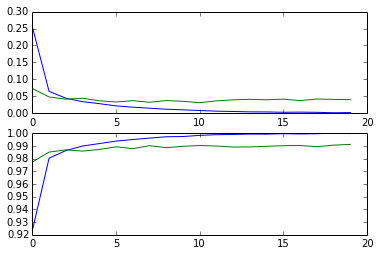

In [11]:
# Traininig curve
epochs = range(training_epochs)
plt.subplot(211)
plt.plot(epochs, save_cost_train, epochs, save_cost_test)
plt.subplot(212)
plt.plot(epochs, save_accr_train, epochs, save_accr_test)

In [12]:
np.argmin(save_cost_test)

10